# Apply MUVINN-reg to register a pair of PAT repeated scans

#### Author: 
Bruno De Santi, PhD
#### Affiliation:
Multi-modality Medical Imaging Lab (M3I Lab), University of Twente, Enschede, The Netherlands
#### Date:
20/09/2023
#### Paper/Project Title:
Automated three-dimensional image registration for longitudinal photoacoustic imaging (De Santi et al. 2023, JBO)
#### GitHub:
https://github.com/brunodesanti/muvinn-reg
#### License:
[Specify the license, e.g., MIT, GPL, etc.]

### Import libraries

In [1]:
from models import models
from utils import processing as proc
from utils import visualizing as vis
from utils import evaluating as eva

import matplotlib.pyplot as plt
import numpy as np
import os 
import torch
import scipy.ndimage as scnd
import SimpleITK as sitk

plot_flag = True # if one wants to plot figures
save_flag = True # if one wants to save figures

### Load fixed and moving images

<Figure size 640x480 with 0 Axes>

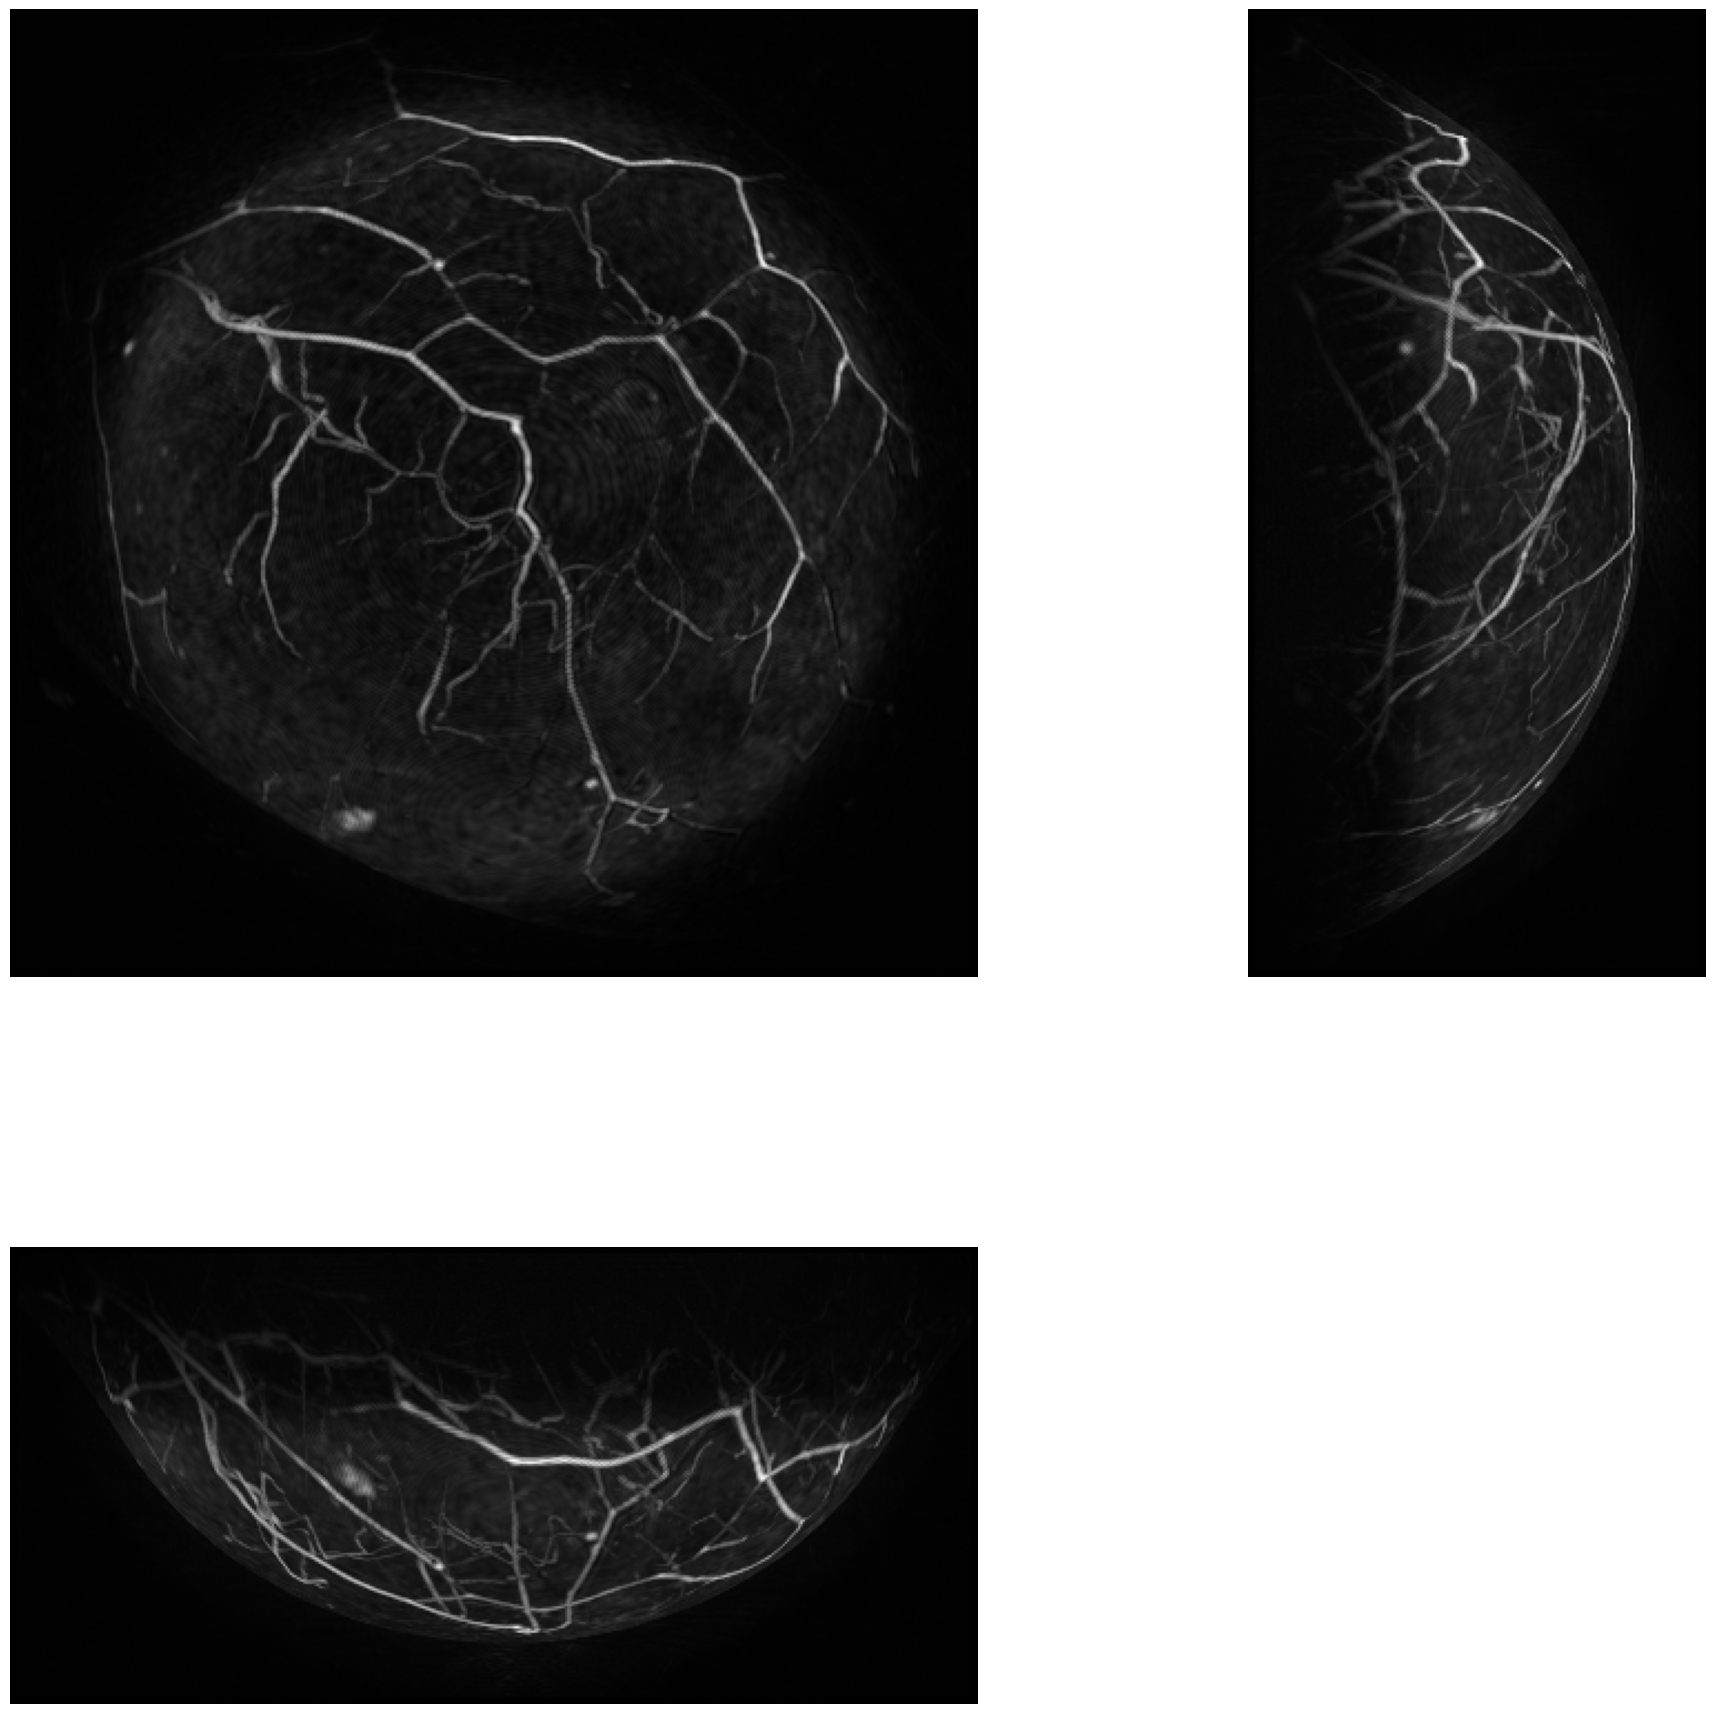

<Figure size 640x480 with 0 Axes>

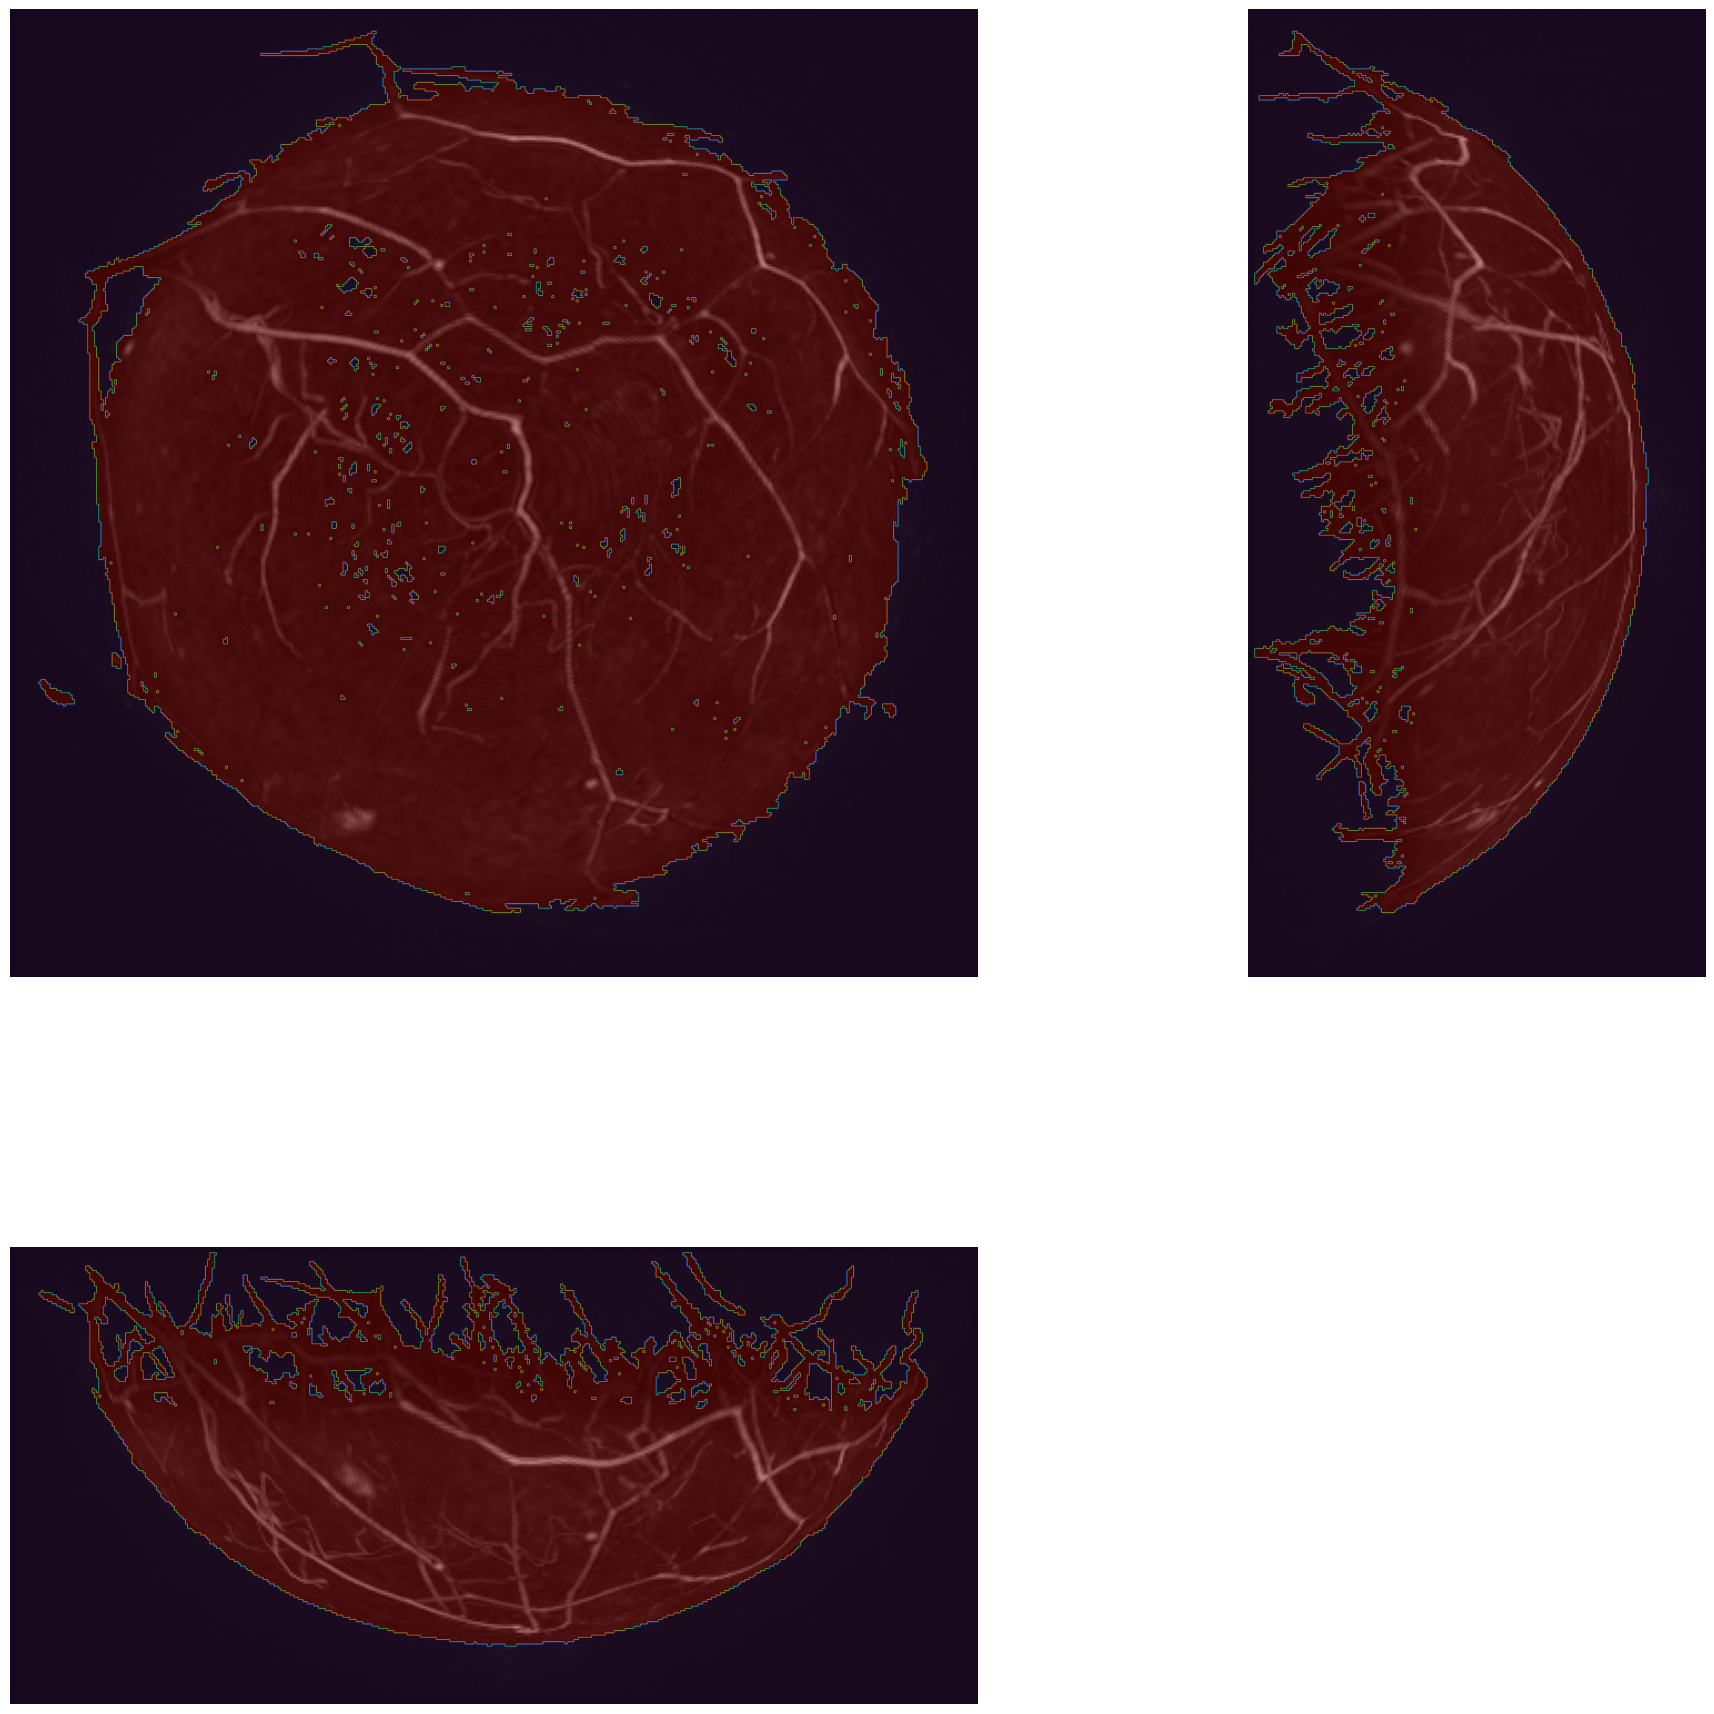

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [2]:
# Load images
fixed_image = np.load('fixed_image.npy')
moving_image = np.load('moving_image.npy')

# Load mask of the fixed image (to sample coordinates only inside the mask)
fixed_mask = np.load('fixed_mask.npy')

# Padding to avoid interpolation errors in the edges
fixed_image = proc.pad_rec(fixed_image, ((3, 3), (3, 3),(3, 3)))
moving_image = proc.pad_rec(moving_image, ((3, 3), (3, 3),(3, 3)))
fixed_mask = proc.pad_rec(fixed_mask, ((3, 3), (3, 3),(3, 3)))

# Plot and save MIPs
if plot_flag:
    plt.figure()
    fig = vis.plot_mips(fixed_image)
    fig.tight_layout()
    if save_flag:
        fig.savefig(r'fixed_image.png')
        
    # Plot and save RGB overlays before co-registration
    plt.figure()
    fig = vis.plot_mips(fixed_image, fixed_mask)
    fig.tight_layout()
    if save_flag:
        fig.savefig(r'fixed_mask.png')
        
    plt.figure()
    fig = vis.plot_mips(moving_image)
    fig.tight_layout()
    if save_flag:
        fig.savefig(r'moving_image.png')

    # Plot and save RGB overlays before co-registration
    plt.figure()
    fig = vis.plot_aligned_mips(moving_image, fixed_image, alpha = 0.5)
    fig.tight_layout()
    if save_flag:
        fig.savefig(r'overlay_before.png')

### Run MUVINN-reg

In [ ]:
# Convert to CUDA tensor
fixed_image_t = torch.FloatTensor(fixed_image).cuda()
moving_image_t = torch.FloatTensor(moving_image).cuda()

# MUVINN-reg settings and parameters
kwargs = {}
kwargs['mask'] = fixed_mask

# Number of epochs
kwargs['epochs'] = 10000
# Total number of points to be sampled each iteration
kwargs['batch_size'] = 150 * (5 ** 3)

# Sigma values during optimization
kwargs['frangi_sigmas'] = np.array([7, 5, 3, 1.5])

# Epochs for each sigma as percentage of total number of epochs
frangi_interval = np.array([0.25, 0.25, 0.25, 0.25]) 
kwargs['frangi_epochs'] = np.insert(np.cumsum(np.floor(frangi_interval*kwargs['epochs']))[:-1],0,0)

# Data term loss function
kwargs['loss_function'] = 'ncc'
# Width of local patches around sampled points
kwargs['ncc_widths'] = 2*kwargs['frangi_sigmas']/100

# Regularization
kwargs['jacobian_regularization'] = True
kwargs['alpha_jacobian'] = 1
kwargs['hyper_regularization'] = False
kwargs['alpha_hyper'] = 0.25

# Network architecture
kwargs['layers'] = [3,300,300,300,300,300,300,3]
kwargs['omega'] = 30

# Optimizer settings
kwargs['optimizer'] = 'adam' 
kwargs['lr'] = 5e-5

# Decrease learning rate when decreasing sigma
kwargs['scheduler_ms'] = kwargs['frangi_epochs'] # MultiStepLR scheduler parameters
kwargs['scheduler_gamma'] = 0.95

# If true print results during optimization
kwargs['verbose'] = False 
# Folder where to save verbose results if verbose is true
kwargs['save_folder'] = r'\verbose'
# Verbose interval in epochs
kwargs['log_interval'] = int(kwargs['epochs']/4)

# Frangi parameters inside optimization
frangi_options = dict()
frangi_options['alpha'] = 0.5
frangi_options['beta'] = 0.5
frangi_options['gamma'] = 0.1
frangi_options['bw_flag'] = True # White voxels are vessels
kwargs['frangi_options'] = frangi_options

# Adaptive intensity modulation parameters inside optimization
aim_options = dict()
aim_options['half_size_win'] = 5
aim_options['min_sd'] = 0.1

# Initialize model
ImpReg = models.ImplicitRegistrator(moving_image_t, fixed_image_t, **kwargs)
# Run model optimization
ImpReg.train()

# Save and plot loss curve
if plot_flag:
    fig = plt.figure(figsize = (20,5))
    plt.plot(ImpReg.data_loss_list) # loss curve
    plt.xlim(xmin=0, xmax = kwargs['epochs'])
    plt.ylim(ymin=-1, ymax = 0)
    ax = plt.gca()
    plt.grid()
    if save_flag:
        fig.savefig(r'loss_muvinn.png')

# Tranform original moving image
# Batches are coordinates are transformed to avoid ut of GPU memory
# forward_batch_size is the batch size
transformed_image = ImpReg(fixed_image.shape, moving_image_t, forward_batch_size = 50000)

# Plot and save RGB overlays after co-registration
if plot_flag:
    plt.figure()
    fig = vis.plot_aligned_mips(transformed_image, fixed_image)
    fig.tight_layout()
    if save_flag:
        fig.savefig(r'muvinn_overlay.png')